# Генерация похожих данных

Здесь на основе предобработанных в Preprocessing.ipynb данных будем генерировать похожие данные.

Для этого будем использовать библиотеку DataSynthesizer.

https://github.com/DataResponsibly/DataSynthesizer

In [1]:
import pandas as pd

In [2]:
pd.options.display.max_columns = None

In [ ]:
!pip install DataSynthesizer

In [ ]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

Примонтируем Google Drive. На Google Drive хранятся предобработанные данные, и туда мы будем сохранять результат.

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


Зададим пути файлов ввода и вывода.

In [3]:
# input dataset
input_data = '/content/drive/MyDrive/Интеллектуальный анализ данных в бизнесе 2 Гурьянов 11-909/Задача 2/fns_fiscal_preprocessed.csv'
# location of two output files
mode = 'correlated_attribute_mode'
description_file = '/content/drive/MyDrive/Интеллектуальный анализ данных в бизнесе 2 Гурьянов 11-909/Задача 2/fns_fiscal_generated_description.json'
synthetic_data = '/content/drive/MyDrive/Интеллектуальный анализ данных в бизнесе 2 Гурьянов 11-909/Задача 2/fns_fiscal_generated.csv'

In [ ]:
data = pd.read_csv(input_data)
data.head()

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value
0,2.0,1,24,50175,50175,8363.0,2020-09-16,3.0,1,556,1.0,onlineoplata@esplus.ru,onlineoplata@esplus.ru,Missing,Missing,Missing,Missing,Missing,Missing,0.0,0.0,Missing,Missing,Missing,Missing
1,2.0,1,24,25420,25420,4237.0,2020-09-16,3.0,1,565,1.0,onlineoplata@esplus.ru,onlineoplata@esplus.ru,Missing,Missing,Missing,Missing,Missing,Missing,0.0,0.0,Missing,Missing,Missing,Missing
2,Missing,1,14,6000,6000,0.0,2020-09-16,3.0,0,529,Missing,Missing,+79091082396,Missing,Missing,Missing,Missing,Missing,Missing,0.0,1000.0,Missing,Missing,Missing,Missing
3,Missing,1,14,10000,10000,0.0,2020-09-16,3.0,0,537,Missing,Missing,+79092626865,Missing,Missing,Missing,Missing,Missing,Missing,0.0,1667.0,Missing,Missing,Missing,Missing
4,Missing,1,14,20000,20000,0.0,2020-09-16,3.0,0,553,Missing,Missing,+79089895687,Missing,Missing,Missing,Missing,Missing,Missing,0.0,3333.0,Missing,Missing,Missing,Missing


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   protocolVersion              797 non-null    object 
 1   operationType                797 non-null    int64  
 2   shiftNumber                  797 non-null    int64  
 3   totalSum                     797 non-null    int64  
 4   ecashTotalSum                797 non-null    int64  
 5   nds18                        797 non-null    float64
 6   dateTime                     797 non-null    object 
 7   receiptCode                  797 non-null    object 
 8   taxationType                 797 non-null    int64  
 9   requestNumber                797 non-null    int64  
 10  internetSign                 797 non-null    object 
 11  senderAddress                797 non-null    object 
 12  buyerAddress                 797 non-null    object 
 13  userProperty.key    

## Анализ данных

categorical_attributes содержит названия категориальных столбцов.

In [ ]:
categorical_attributes_list = list(data.select_dtypes(['object']).columns)

categorical_attributes_list.append('dateTime')
categorical_attributes_list.append('operationType')
categorical_attributes_list.append('taxationType')
#categorical_attributes_list.append('fiscalDocumentNumber')

categorical_attributes = {}

for categorical_attribute in categorical_attributes_list:
    categorical_attributes[categorical_attribute] = True

    

In [ ]:
categorical_attributes

{'buyerAddress': True,
 'code': True,
 'dateTime': True,
 'fiscalDocumentFormatVer': True,
 'internetSign': True,
 'operationType': True,
 'paymentAgentType': True,
 'propertiesUser.propertyName': True,
 'propertiesUser_key': True,
 'propertiesUser_value': True,
 'protocolVersion': True,
 'receiptCode': True,
 'retailAddress': True,
 'sellerAddress': True,
 'senderAddress': True,
 'taxationType': True,
 'userProperty.key': True,
 'userProperty.value': True}

С помощью attribute_to_datatype можно явно задать для анализатора данных тип столбца. Обычно это не требуется, так как тип данных определяется автоматически. Но тип столбца 'receiptCode' определялся неправильно.

In [ ]:
attribute_to_datatype = {'receiptCode': 'String'}

Все признаки, содержащие меньше, чем threshold_value значений, считаются категориальными. В данном случае я не использовал этот гиперпараметр, а задал перечень категориальных столбцов явно.

Увеличение degree_of_bayesian_network может повысить качество генерации данных, но значительно увеличивает время работы.

epsilon нужен для Differential Privacy. Анонимизация данных в нашем случае не нужна, и я отключил ее, задав epsilon=0.

In [ ]:
#threshold_value = 2000
degree_of_bayesian_network = 2
epsilon = 0

С помощью гиперпараметра attribute_to_is_candidate_key можно задать список ключей-кандидатов. Но таких столбцов в датасете нет, даже fiscalDocumentNumber содержит строки с одинаковыми значениями.

Здесь запускается анализатор датасета. Он анализирует входные данные и сохряняет результат анализа в формате json. Именно на основе этого файла будут генерироваться данные.

In [ ]:
describer = DataDescriber()#category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_datatype=attribute_to_datatype,
                                                        attribute_to_is_categorical=categorical_attributes)
                                                        #attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT buyerAddress
Adding attribute requestNumber
Adding attribute senderAddress
Adding attribute shiftNumber
Adding attribute taxationType
Adding attribute nds18
Adding attribute internetSign
Adding attribute nds20
Adding attribute sellerAddress
Adding attribute dateTime
Adding attribute protocolVersion
Adding attribute fiscalDocumentFormatVer
Adding attribute paymentAgentType
Adding attribute retailAddress
Adding attribute ecashTotalSum
Adding attribute userProperty.value
Adding attribute userProperty.key
Adding attribute propertiesUser.propertyName
Adding attribute propertiesUser_value
Adding attribute propertiesUser_key
Adding attribute receiptCode
Adding attribute code
Adding attribute nds10
Adding attribute operationType
Adding attribute totalSum
========================== BN constructed ==========================


In [ ]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    requestNumber               has parents ['buyerAddress'].
    senderAddress               has parents ['requestNumber', 'buyerAddress'].
    shiftNumber                 has parents ['requestNumber', 'buyerAddress'].
    taxationType                has parents ['shiftNumber', 'buyerAddress'].
    nds18                       has parents ['shiftNumber', 'buyerAddress'].
    internetSign                has parents ['requestNumber', 'buyerAddress'].
    nds20                       has parents ['taxationType', 'buyerAddress'].
    sellerAddress               has parents ['internetSign', 'shiftNumber'].
    dateTime                    has parents ['requestNumber', 'buyerAddress'].
    protocolVersion             has parents ['shiftNumber', 'buyerAddress'].
    fiscalDocumentFormatVer     has parents ['shiftNumber', 'buyerAddress'].
    paymentAgentType            has parents ['fiscalDocumentFormatVer', 'internetSign'].
    retailAddress               has pare

## Генерация данных

Здесь мы задаем количество строк, которое будет генерироваться.

100 000 строк — датасет около 180 МБ и 30 минут генерации.

In [ ]:
num_tuples_to_generate = 1000000

Здесь запускается генератор данных.

In [ ]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [ ]:
#!pip show DataSynthesizer

In [ ]:
#!python --version

In [ ]:
#!cat /etc/os-release

## Визуализация

Далее будут визуализированы результаты генерации похожих данных.

In [ ]:
# Read both datasets using Pandas.
input_df = pd.read_csv(input_data, skipinitialspace=True)
synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

На этих гистограммах сравнивается распределение изначальных данных и сгенерированных. Видно, что распределения очень близки.

/usr/local/lib/python3.7/dist-packages/DataSynthesizer/ModelInspector.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 5), dpi=120)


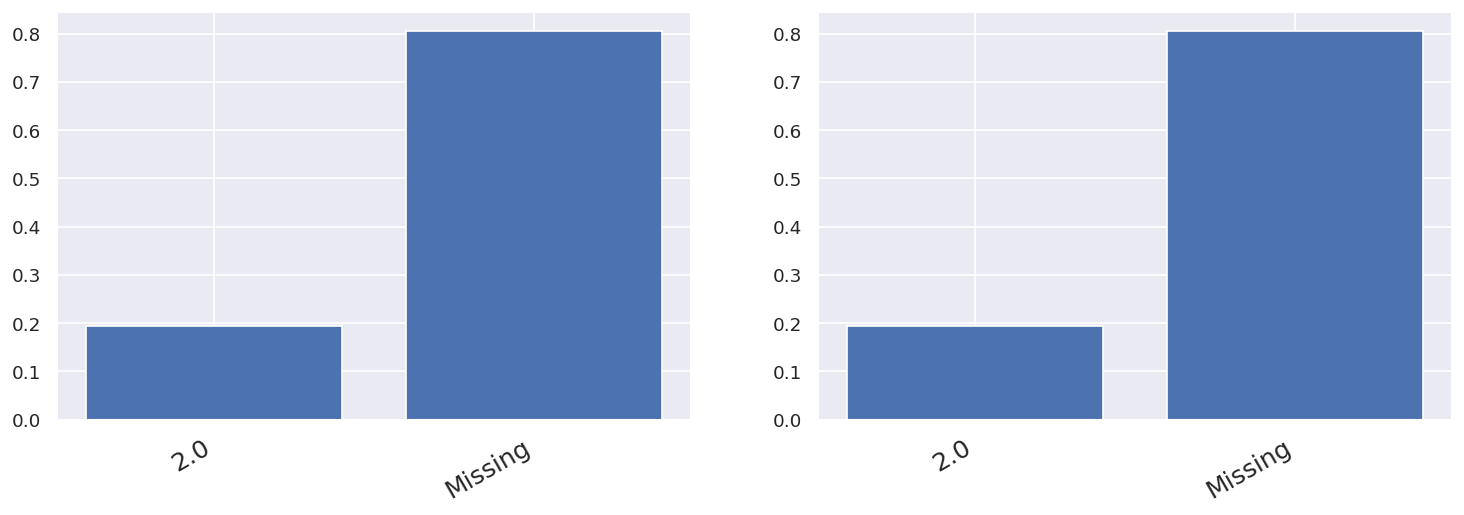

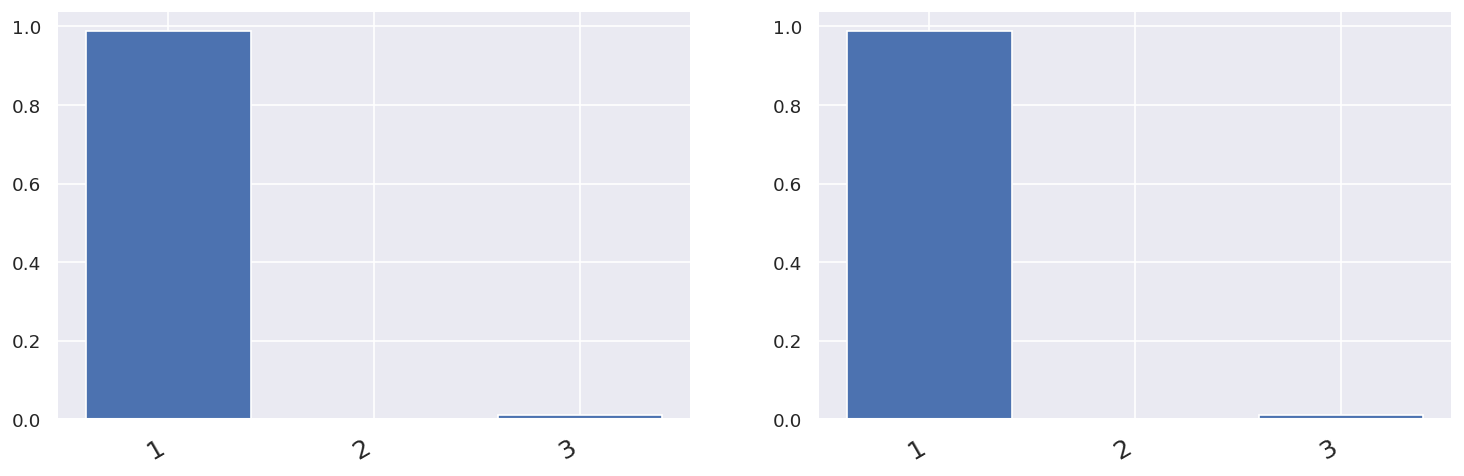

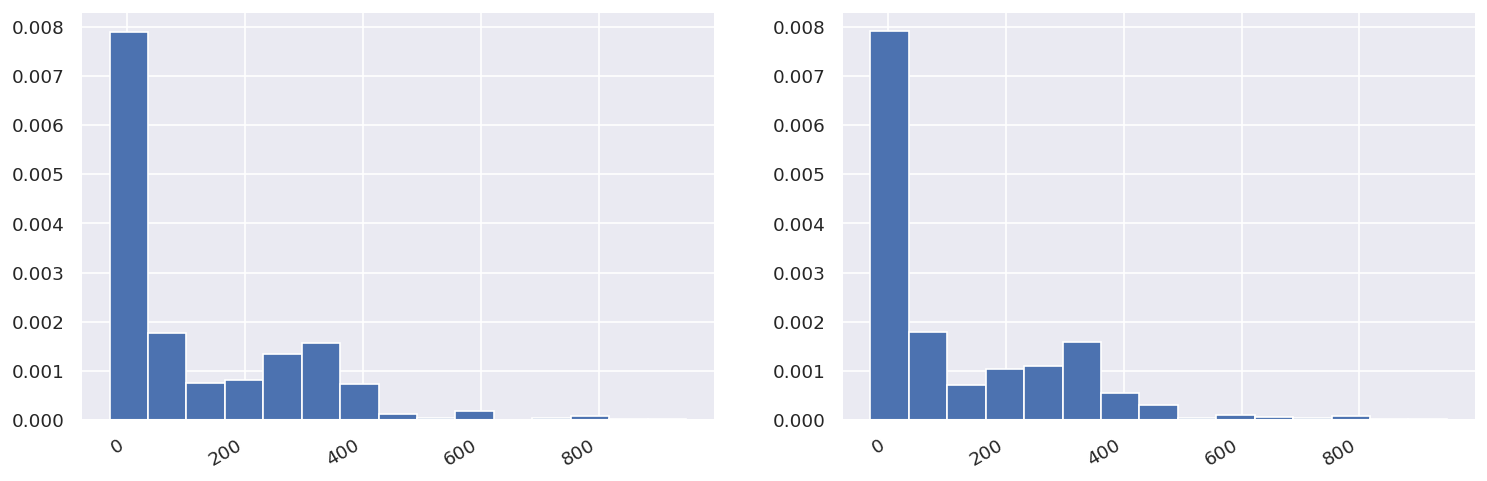

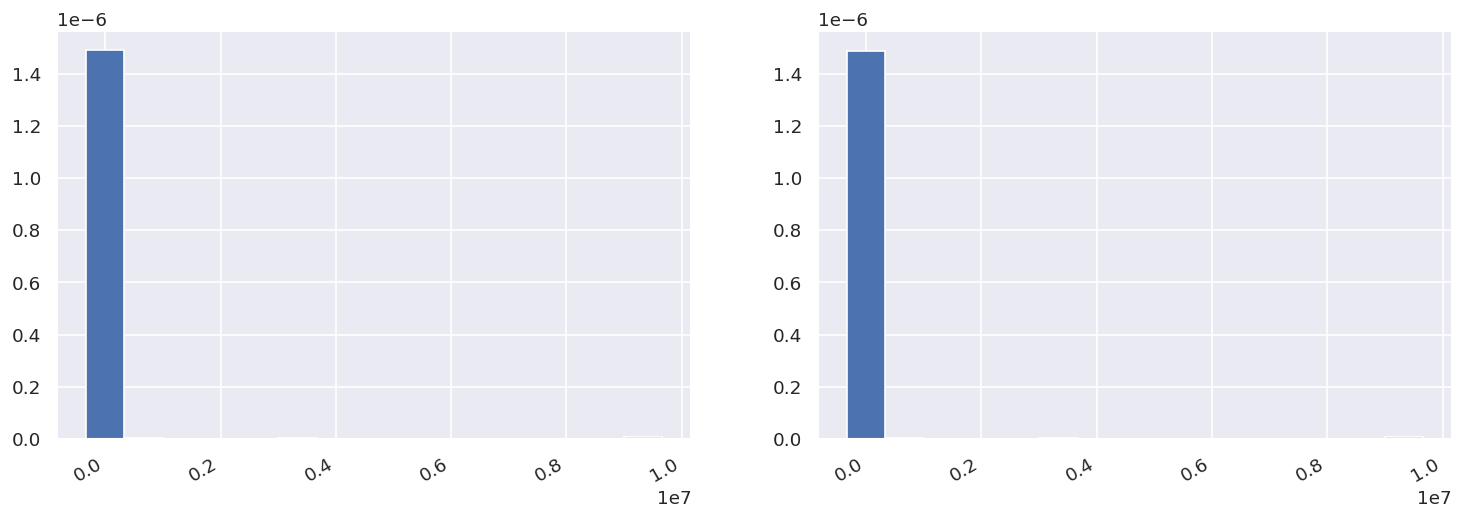

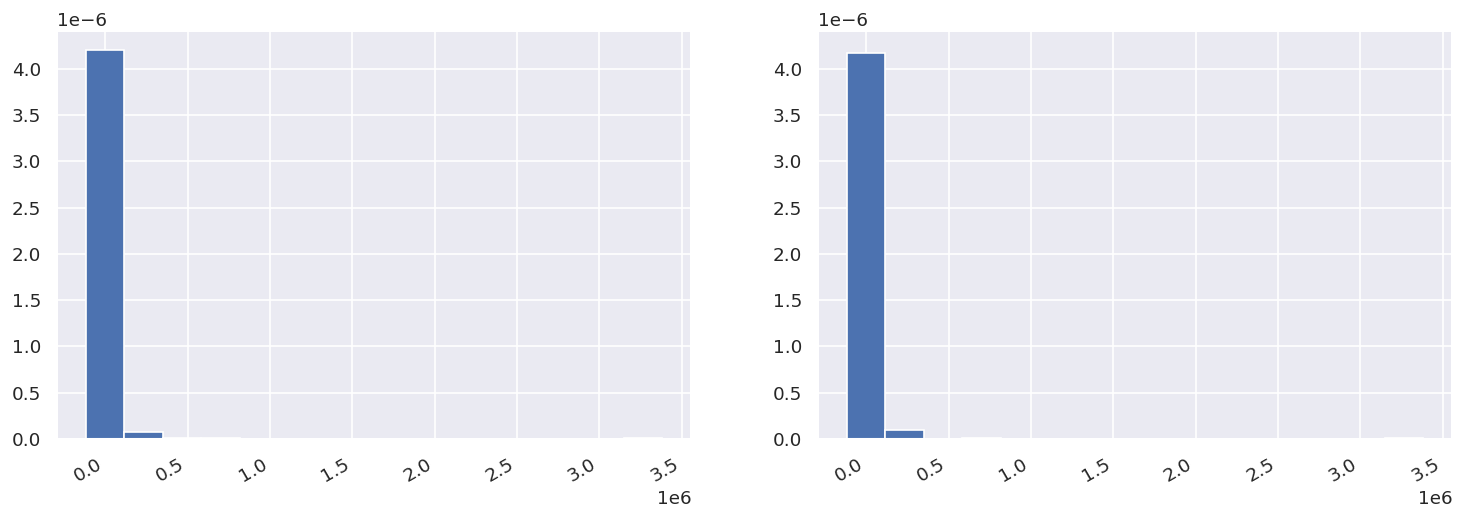

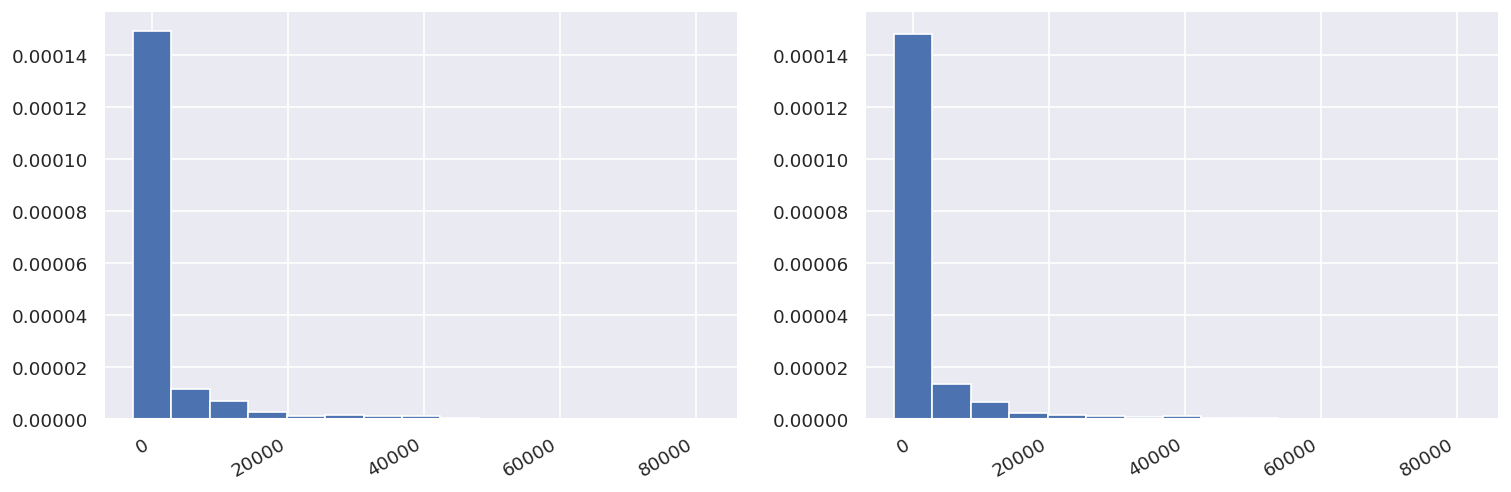

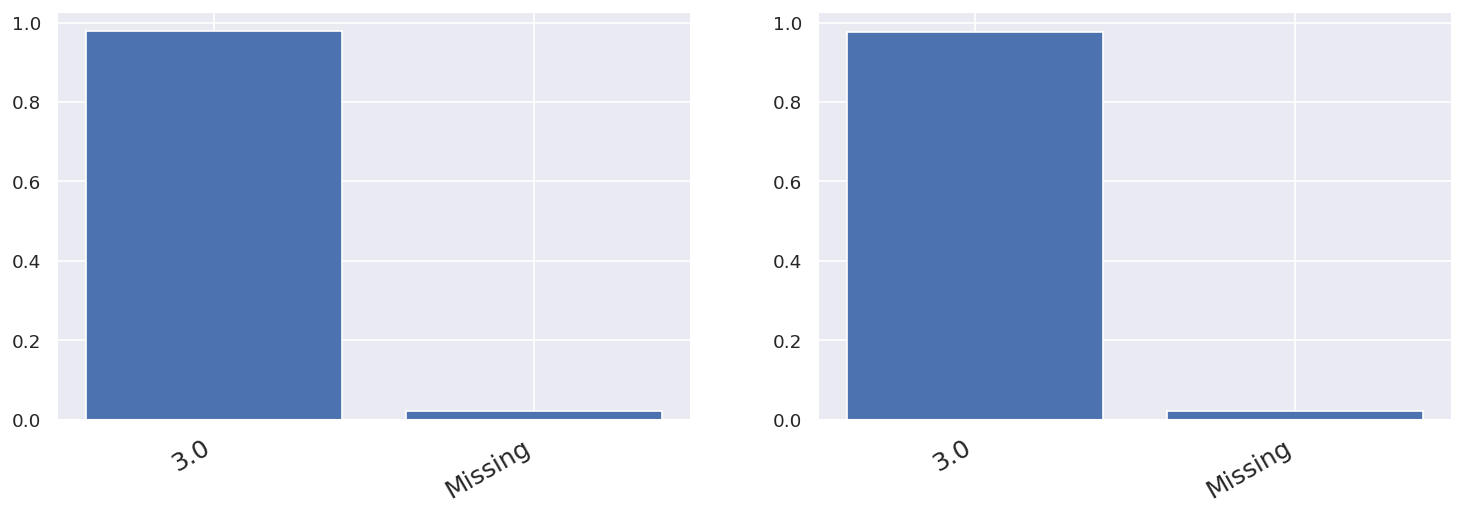

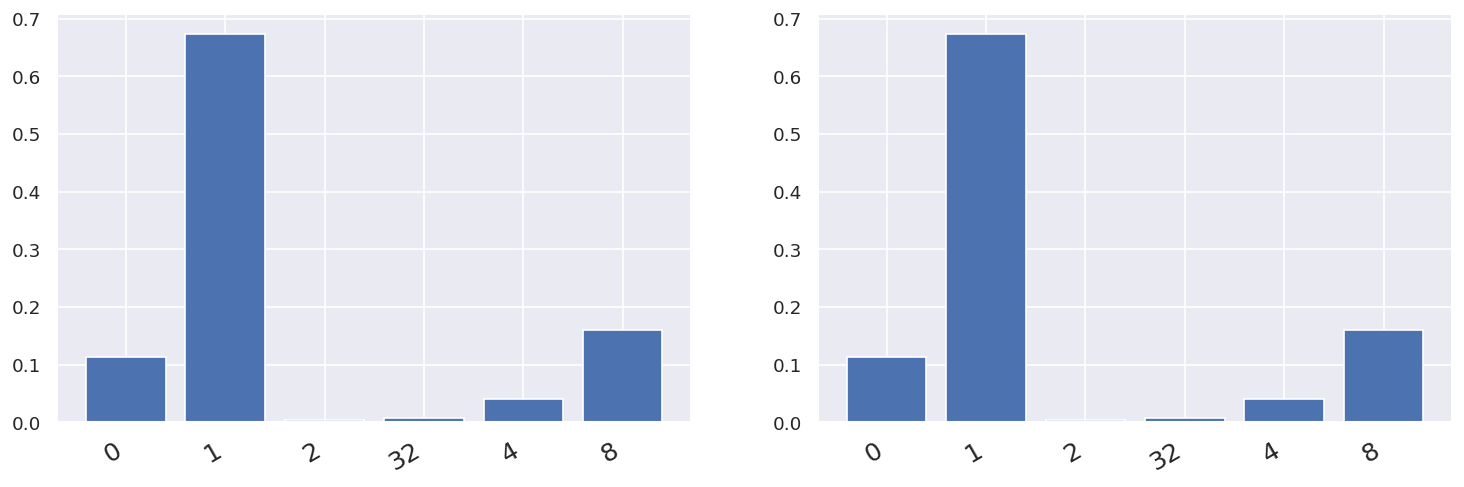

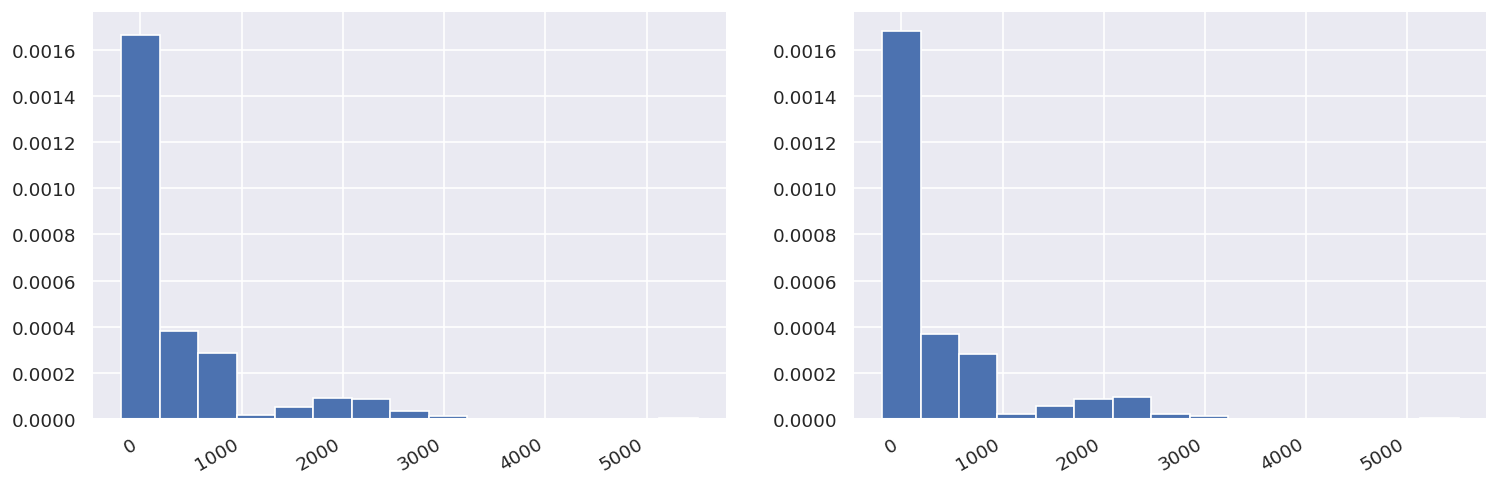

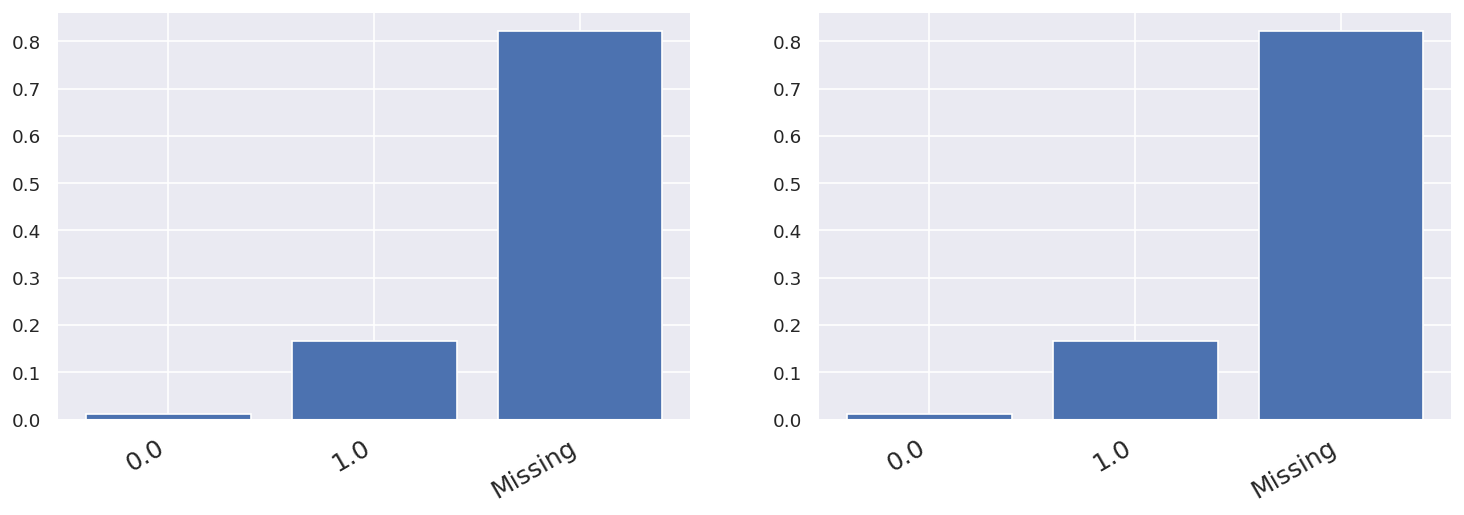

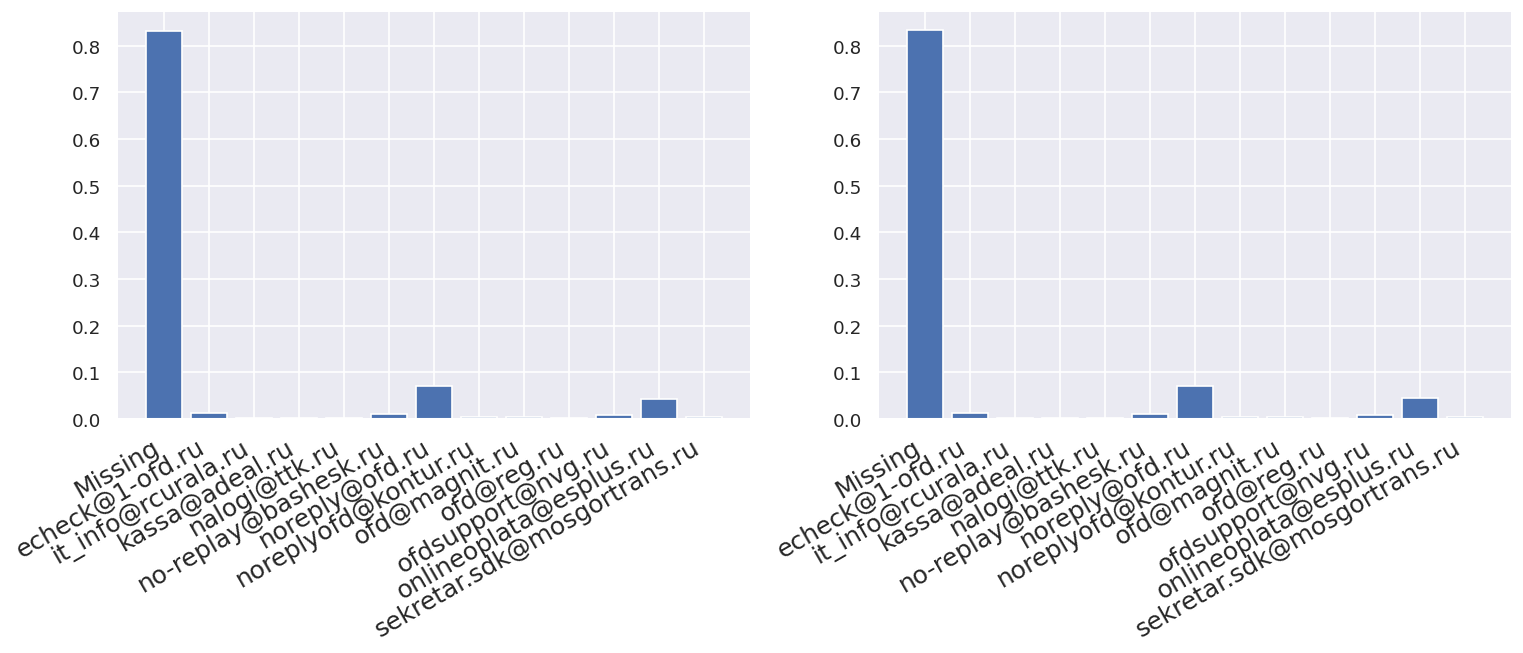

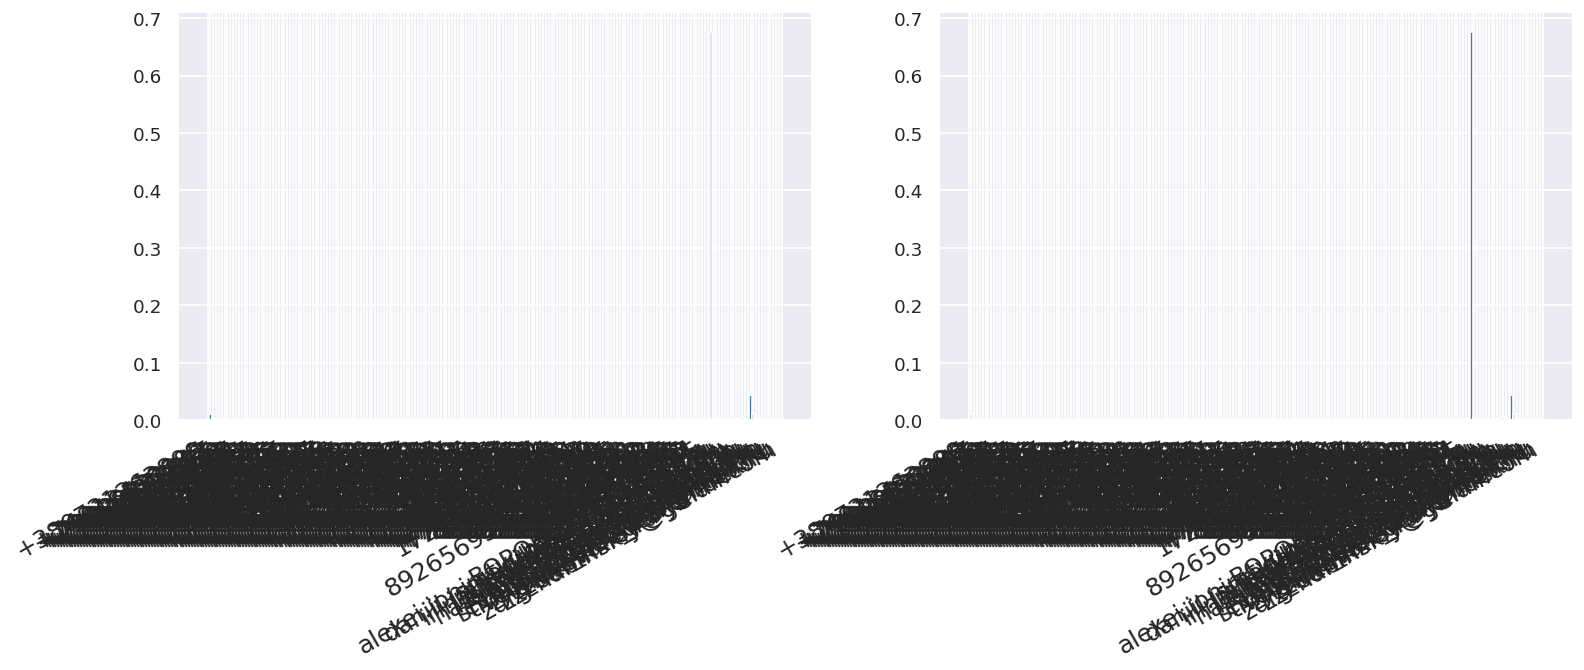

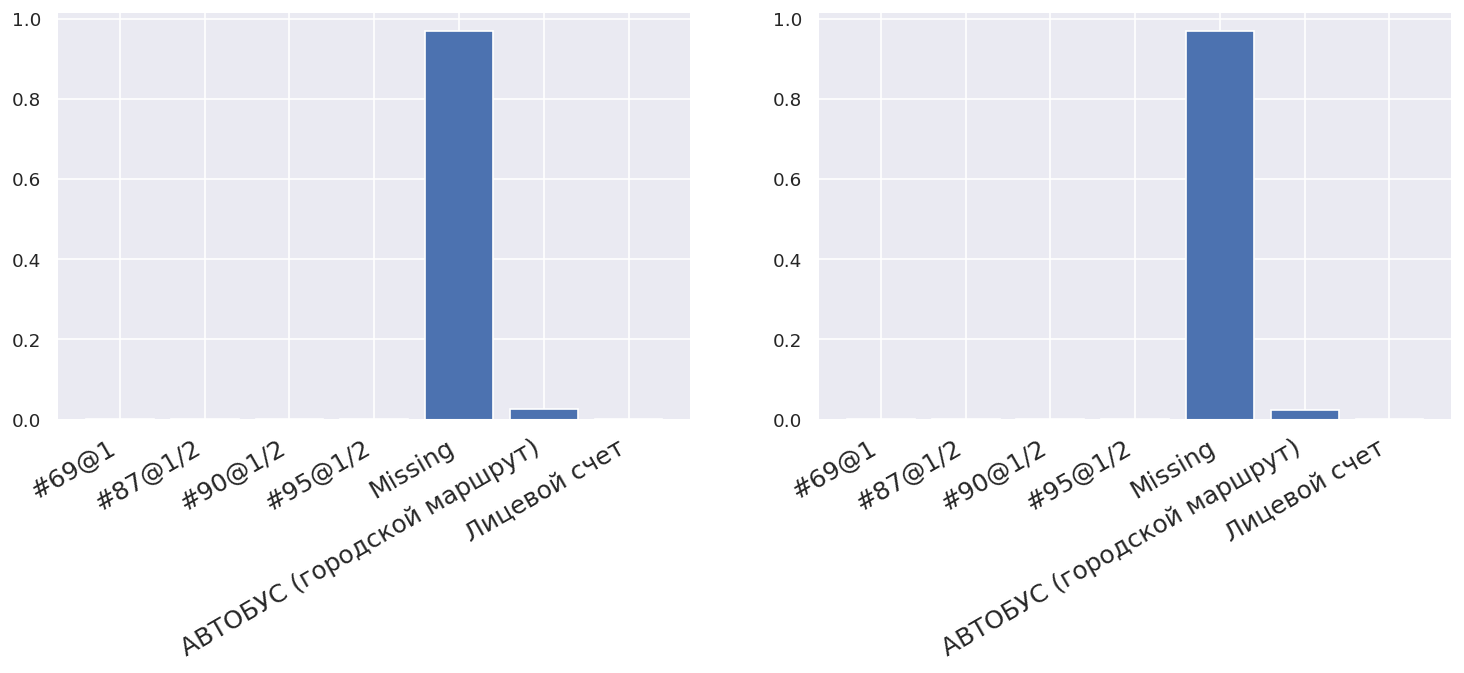

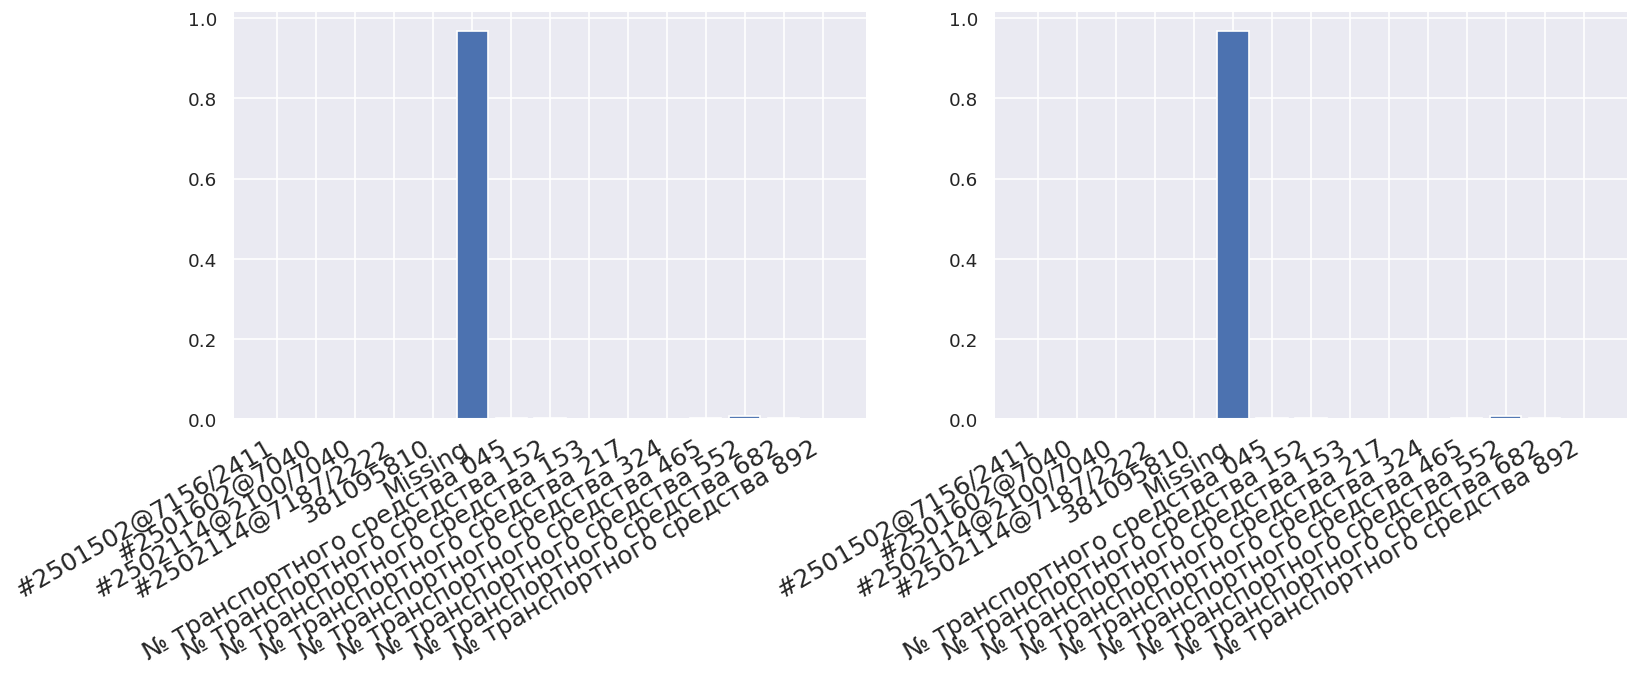

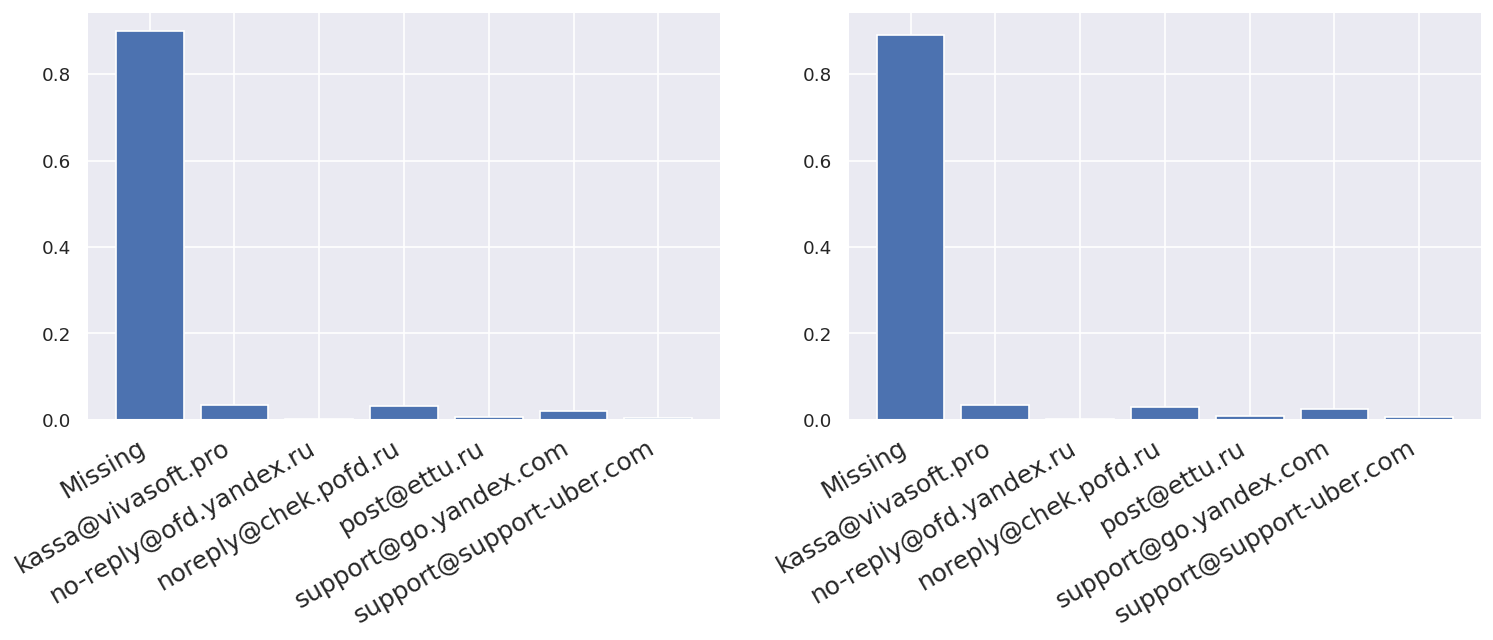

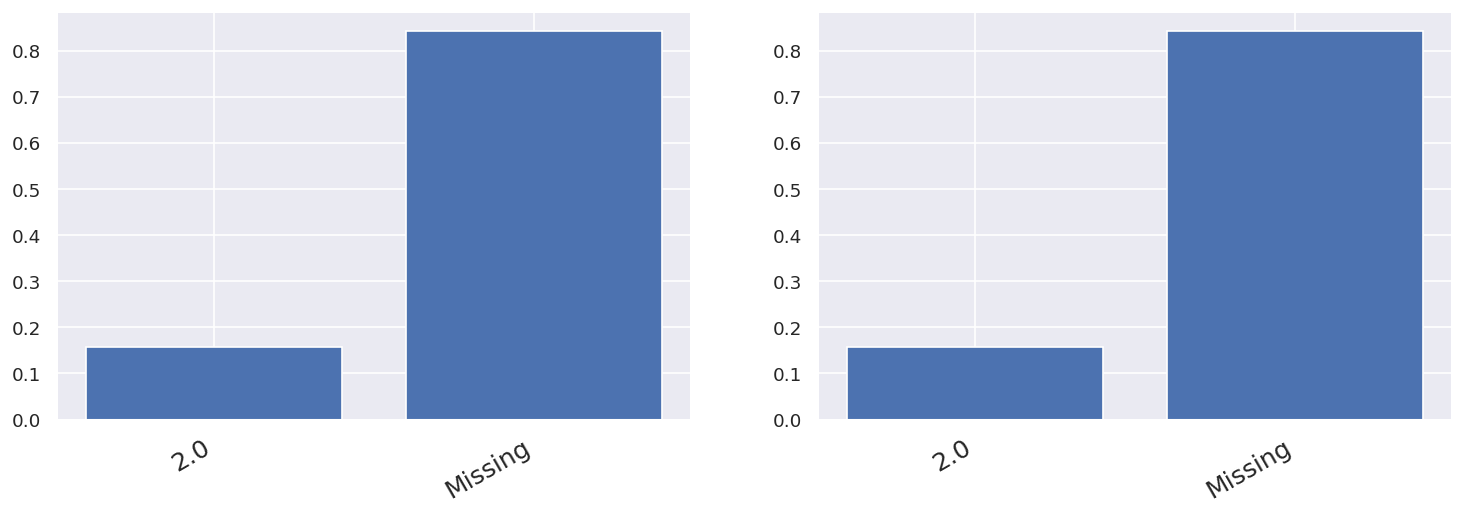

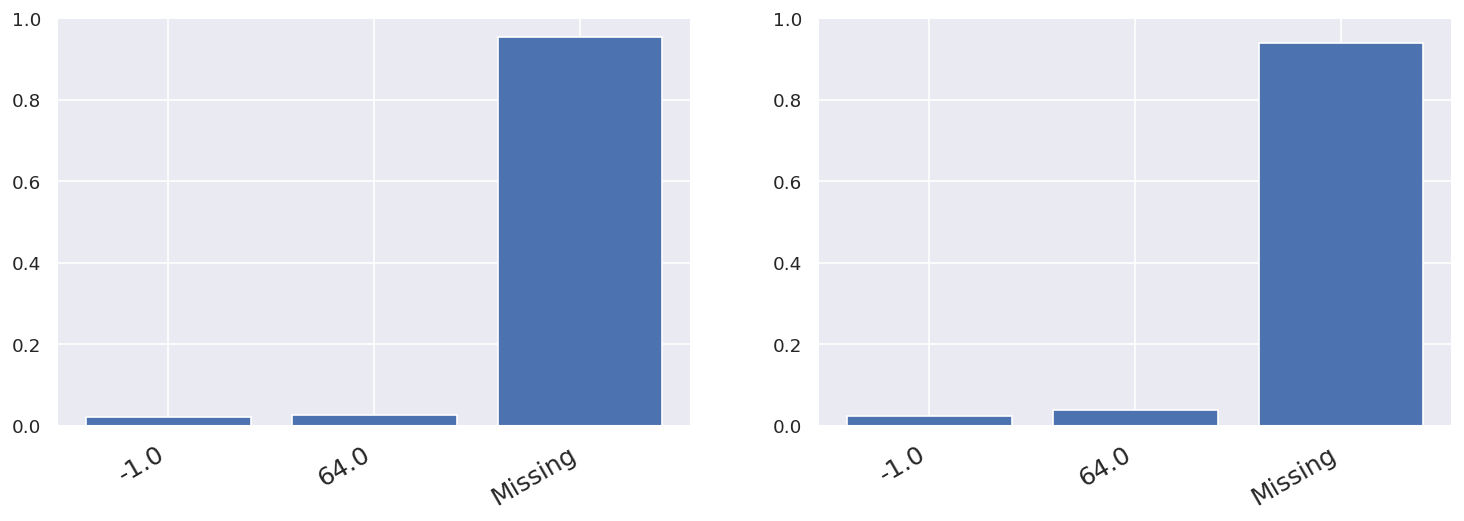

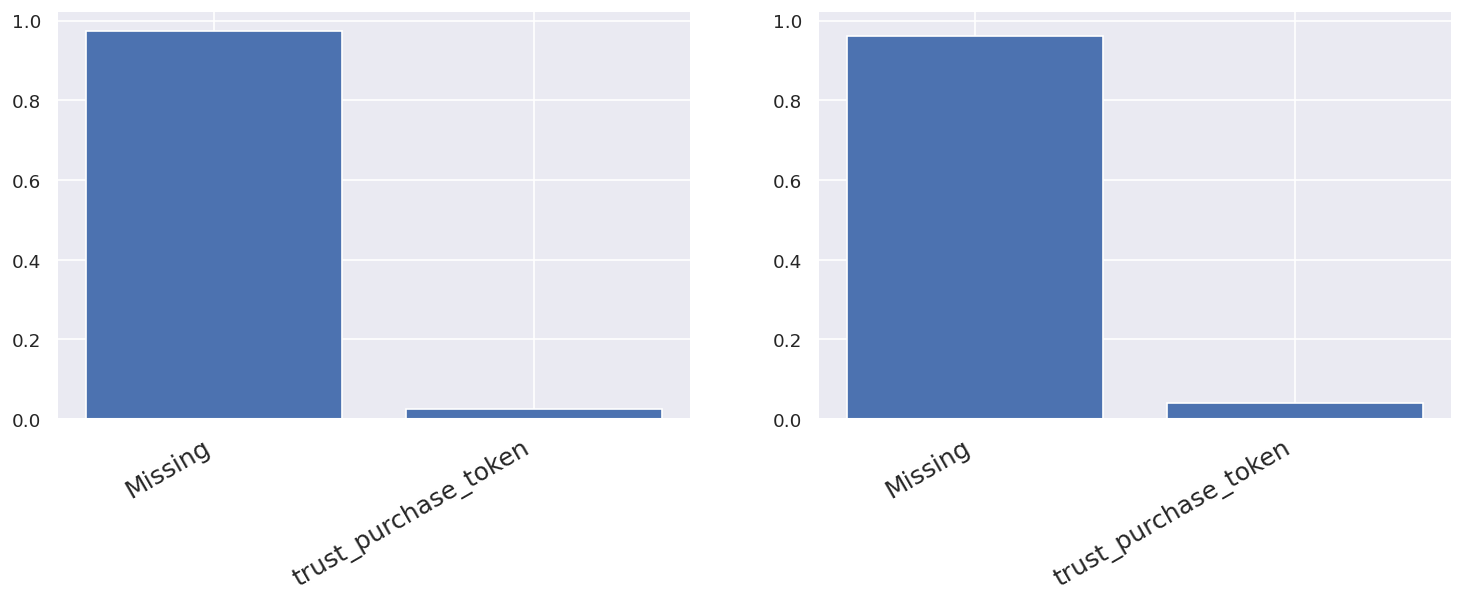

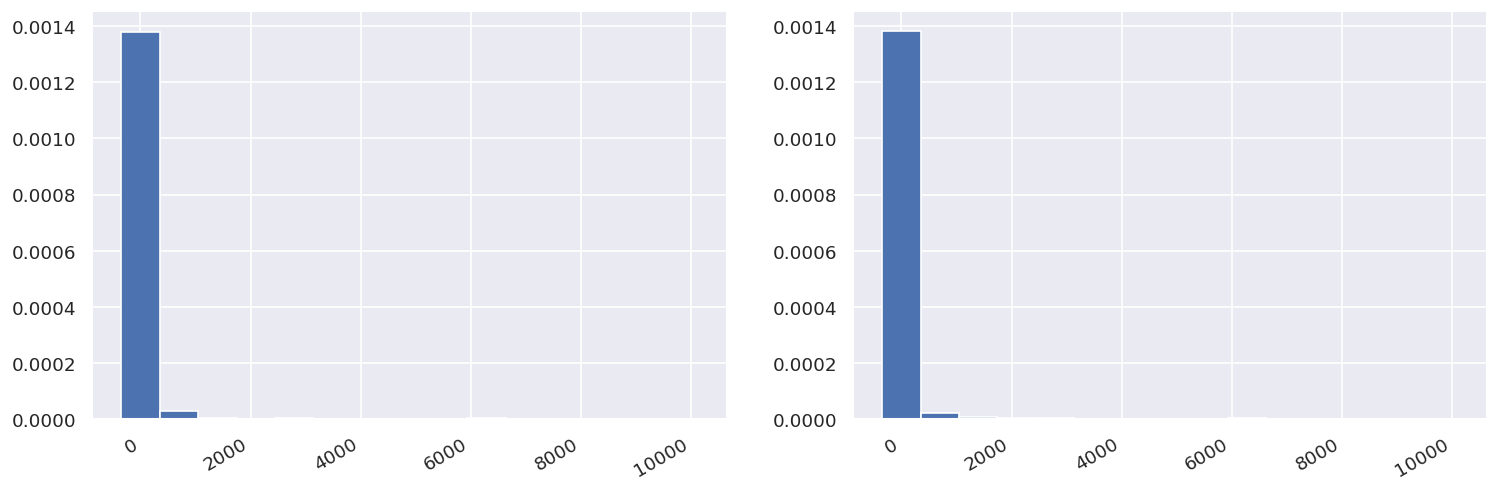

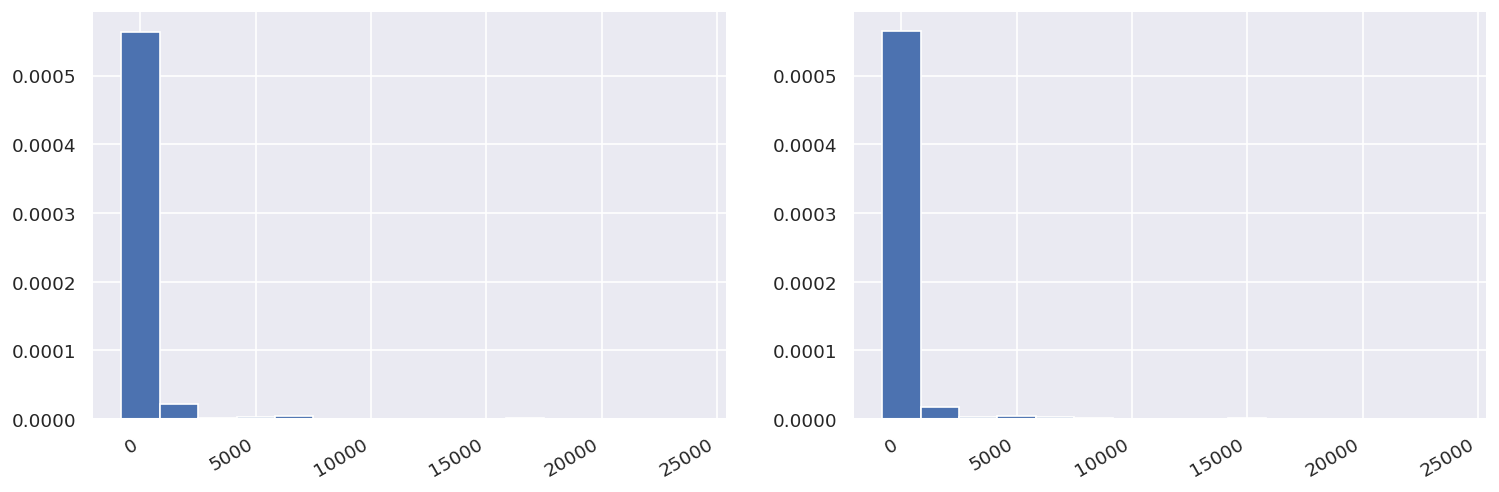

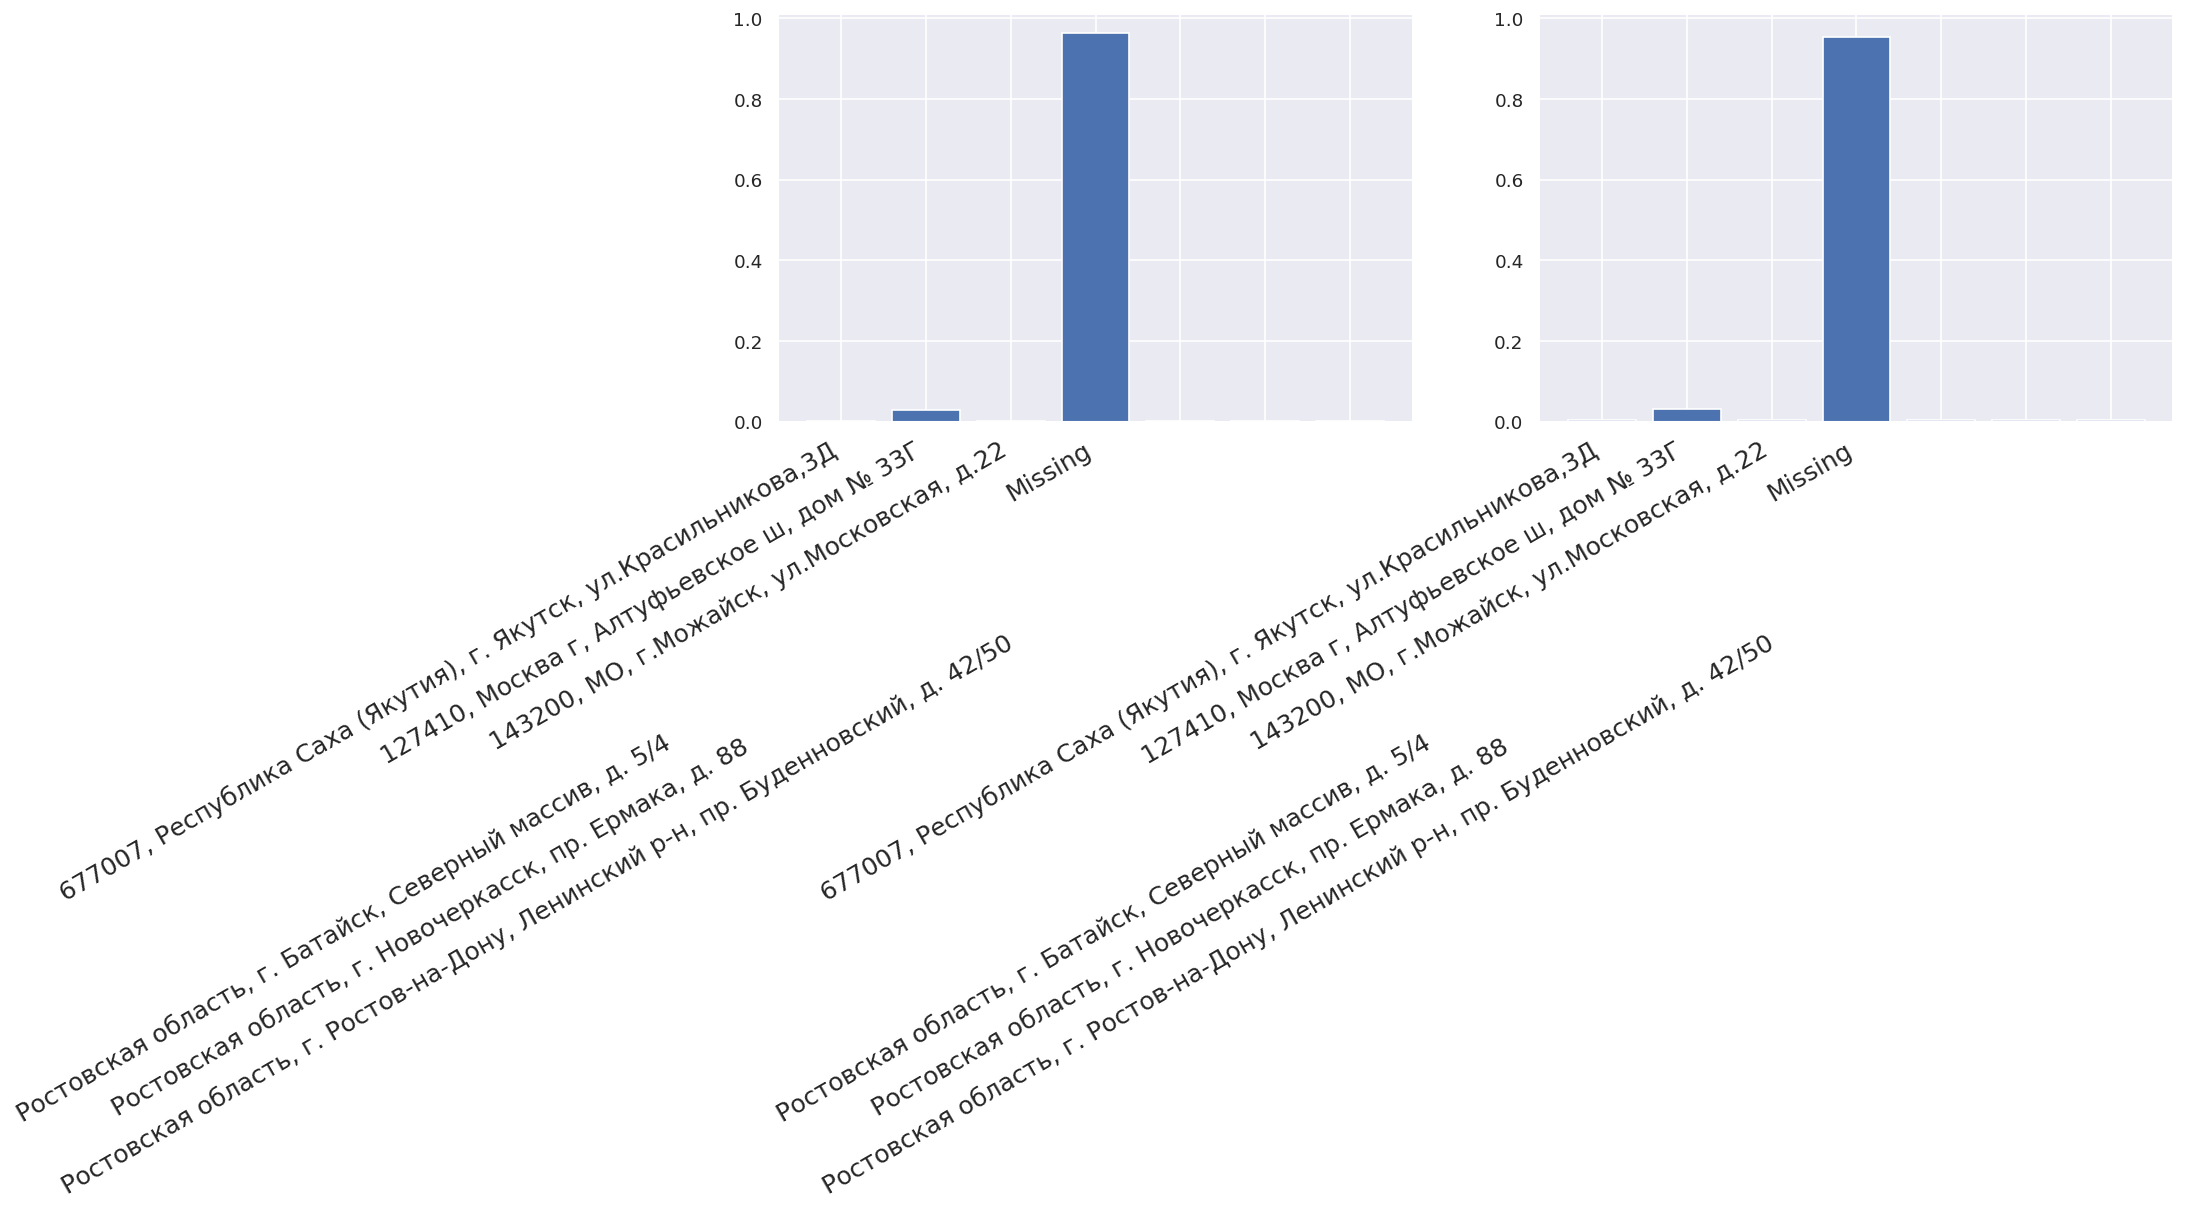

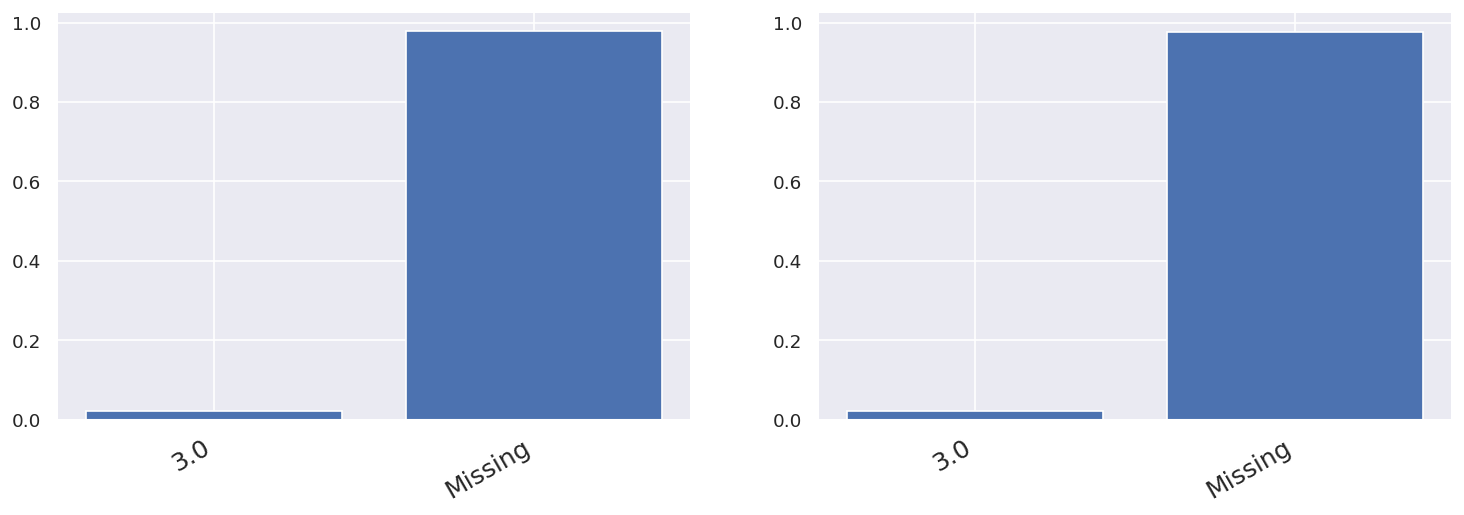

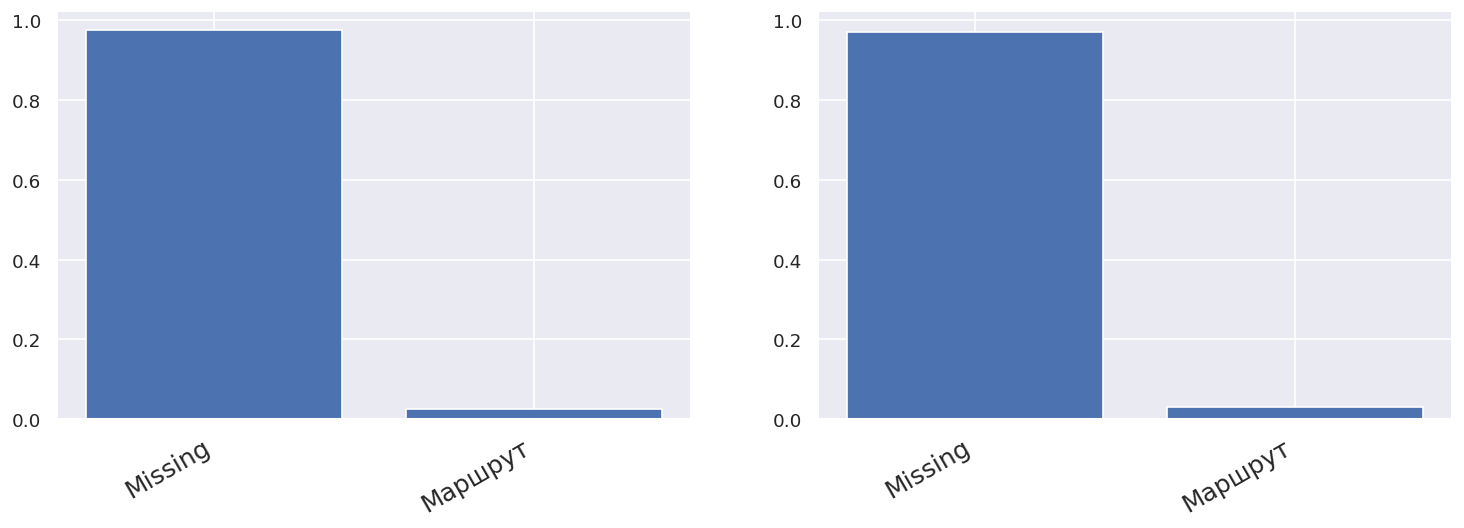

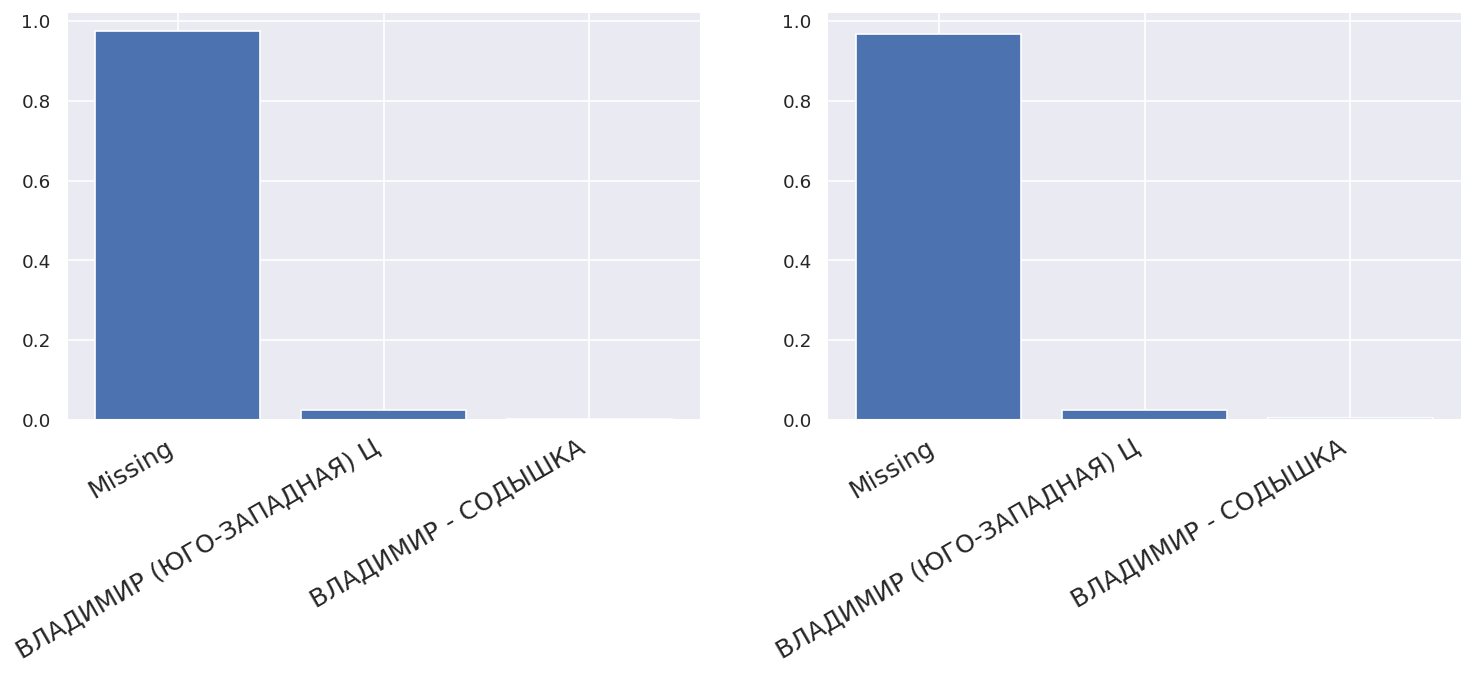

In [ ]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

Здесь показана корреляция столбцов изначальных данных, и корреляция столбцов сгенерированных данных. Как видно, корреляции близки.

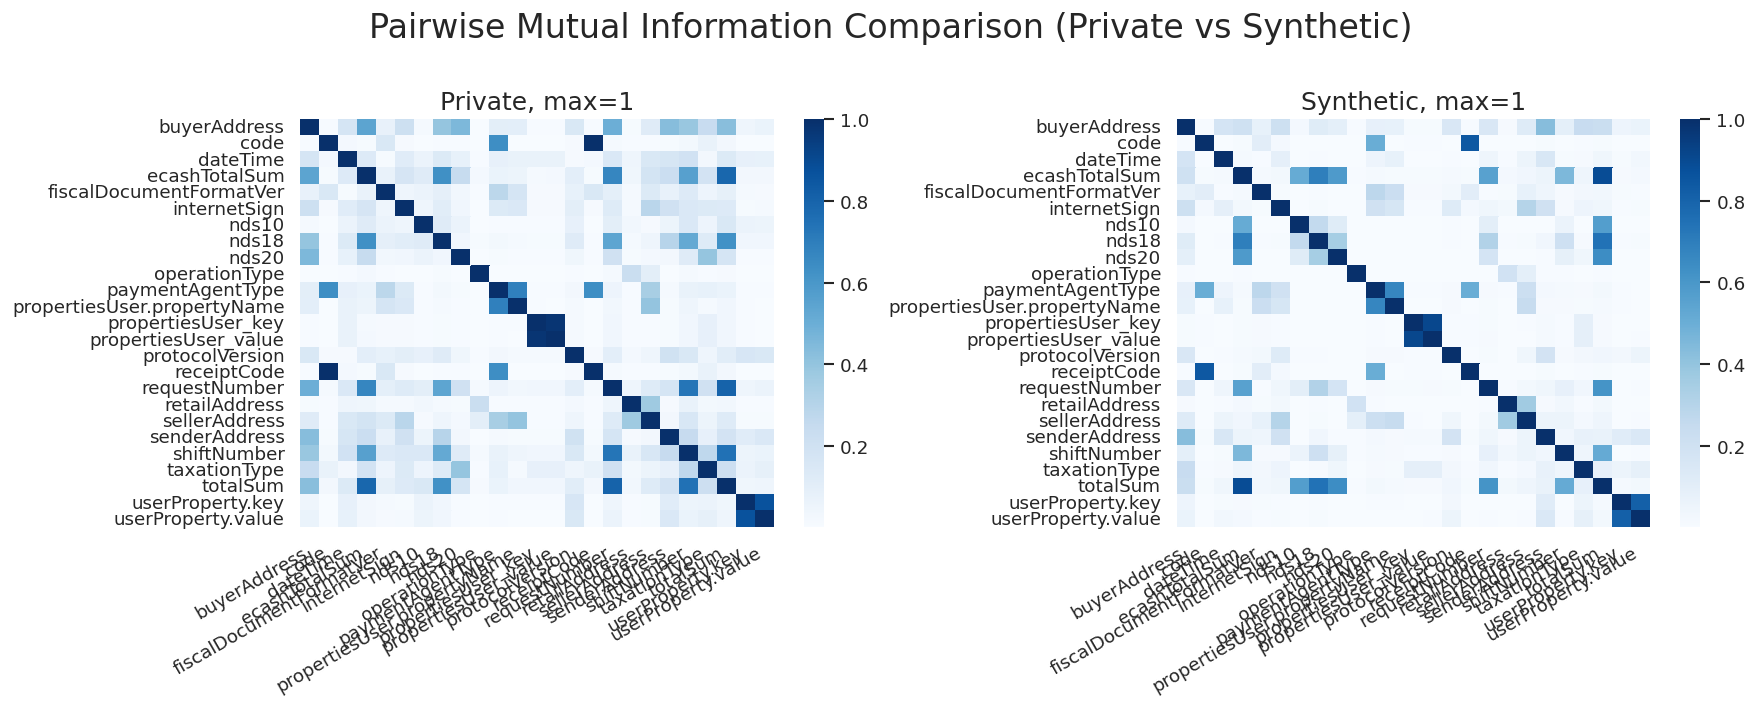

In [ ]:
inspector.mutual_information_heatmap()

In [ ]:
#!pip install dask[dataframe] -q

     |████████████████████████████████| 136 kB 9.6 MB/s 


In [ ]:
#import dask.dataframe as dd

In [5]:
post = pd.read_csv(synthetic_data)
post.head()

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value
0,Missing,1,338.0,172676.0,44748.0,1373.0,2020-09-14,3.0,1,255.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,200.0,578.0,Missing,Missing,Missing,Missing
1,Missing,1,40.0,68548.0,55125.0,1022.0,2020-09-14,3.0,8,1519.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,315.0,917.0,Missing,Missing,Missing,Missing
2,Missing,1,24.0,283157.0,162493.0,3604.0,2020-09-14,3.0,1,168.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,295.0,1189.0,Missing,Missing,Missing,Missing
3,Missing,1,16.0,207016.0,38531.0,4165.0,2020-09-16,3.0,1,42.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,287.0,220.0,Missing,Missing,Missing,Missing
4,Missing,1,370.0,484794.0,91009.0,4174.0,2020-09-14,3.0,8,176.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,145.0,62.0,Missing,Missing,Missing,Missing


In [ ]:
data.query('totalSum < ecashTotalSum')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [6]:
sample = post.query('totalSum < ecashTotalSum')
sample

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [ ]:
post[['totalSum', 'ecashTotalSum']] = post[['totalSum', 'ecashTotalSum']].apply(
    lambda x: pd.Series([x['totalSum'], x['ecashTotalSum']]) if x['totalSum'] >= x['ecashTotalSum'] else pd.Series([x['ecashTotalSum'], x['totalSum']]), axis=1)#, index=sample.index, columns=['totalSum', 'ecashTotalSum'])

In [ ]:
post.head()

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value
0,Missing,1,338.0,172676.0,44748.0,1373.0,2020-09-14,3.0,1,255.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,200.0,578.0,Missing,Missing,Missing,Missing
1,Missing,1,40.0,68548.0,55125.0,1022.0,2020-09-14,3.0,8,1519.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,315.0,917.0,Missing,Missing,Missing,Missing
2,Missing,1,24.0,283157.0,162493.0,3604.0,2020-09-14,3.0,1,168.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,295.0,1189.0,Missing,Missing,Missing,Missing
3,Missing,1,16.0,207016.0,38531.0,4165.0,2020-09-16,3.0,1,42.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,287.0,220.0,Missing,Missing,Missing,Missing
4,Missing,1,370.0,484794.0,91009.0,4174.0,2020-09-14,3.0,8,176.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,145.0,62.0,Missing,Missing,Missing,Missing


In [ ]:
post.query('totalSum < ecashTotalSum')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [ ]:
post.query('totalSum < nds10 + nds18 + nds20')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value
1826,Missing,1,352.0,6117.0,23.0,13869.0,2020-09-16,3.0,1,12.0,1.0,Missing,Missing,Missing,Missing,support@go.yandex.com,Missing,Missing,Missing,510.0,700.0,Missing,Missing,Missing,Missing
5979,Missing,1,342.0,1450.0,886.0,24308.0,2020-09-14,3.0,1,67.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,403.0,540.0,Missing,Missing,Missing,Missing
5988,Missing,1,8.0,3277.0,2219.0,7606.0,2020-09-14,3.0,1,1181.0,Missing,noreply@ofd.ru,89272767422,Missing,Missing,Missing,Missing,Missing,Missing,280.0,17.0,Missing,Missing,Missing,Missing
9878,2.0,1,294.0,4162.0,3108.0,3458.0,2020-09-14,3.0,1,272.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,5948.0,635.0,Missing,Missing,Missing,Missing
15132,Missing,1,44.0,21266.0,19831.0,3202.0,2020-09-16,3.0,0,651.0,Missing,Missing,+79621039094,Missing,Missing,Missing,Missing,Missing,Missing,338.0,24331.0,Missing,Missing,Missing,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984534,Missing,1,43.0,1419.0,444.0,3501.0,2020-09-14,3.0,8,2488.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,260.0,361.0,Missing,Missing,Missing,Missing
985550,Missing,1,114.0,17840.0,15509.0,16782.0,2020-09-14,3.0,8,243.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,482.0,988.0,Missing,Missing,Missing,Missing
986940,2.0,1,37.0,9124.0,1663.0,22106.0,2020-09-16,3.0,1,835.0,1.0,onlineoplata@esplus.ru,onlineoplata@esplus.ru,Missing,Missing,Missing,Missing,Missing,Missing,205.0,1175.0,Missing,Missing,Missing,Missing
987196,Missing,1,23.0,14366.0,5936.0,17042.0,2020-09-14,3.0,1,2741.0,Missing,noreply@ofd.ru,shuma-051179@yandex.ru,Missing,Missing,Missing,Missing,Missing,Missing,397.0,358.0,Missing,Missing,Missing,Missing


In [ ]:
#data.query('totalSum * 0.1 + totalSum * 0.18 + totalSum * 0.2 < nds10 + nds18 + nds20')
data.query('totalSum < nds10 / 0.1 + nds18 / 0.18 + nds20 / 0.2')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [7]:
post.query('totalSum < nds10 / 0.1 + nds18 / 0.18 + nds20 / 0.2')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [ ]:
from math import ceil

In [ ]:
post['totalSum'] = post.apply(lambda x: x['totalSum'] if x['totalSum'] >= x['nds10'] / 0.1 + x['nds18'] / 0.18 + x['nds20'] / 0.2 else ceil(x['nds10'] / 0.1 + x['nds18'] / 0.18 + x['nds20'] / 0.2), axis=1)

In [ ]:
post.head()

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value
0,Missing,1,338.0,172676.0,44748.0,1373.0,2020-09-14,3.0,1,255.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,200.0,578.0,Missing,Missing,Missing,Missing
1,Missing,1,40.0,68548.0,55125.0,1022.0,2020-09-14,3.0,8,1519.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,315.0,917.0,Missing,Missing,Missing,Missing
2,Missing,1,24.0,283157.0,162493.0,3604.0,2020-09-14,3.0,1,168.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,295.0,1189.0,Missing,Missing,Missing,Missing
3,Missing,1,16.0,207016.0,38531.0,4165.0,2020-09-16,3.0,1,42.0,Missing,Missing,Missing,Missing,Missing,Missing,2.0,Missing,Missing,287.0,220.0,Missing,Missing,Missing,Missing
4,Missing,1,370.0,484794.0,91009.0,4174.0,2020-09-14,3.0,8,176.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,145.0,62.0,Missing,Missing,Missing,Missing


In [ ]:
post.query('totalSum < nds10 / 0.1 + nds18 / 0.18 + nds20 / 0.2')

,protocolVersion,operationType,shiftNumber,totalSum,ecashTotalSum,nds18,dateTime,receiptCode,taxationType,requestNumber,internetSign,senderAddress,buyerAddress,userProperty.key,userProperty.value,sellerAddress,fiscalDocumentFormatVer,paymentAgentType,propertiesUser.propertyName,nds10,nds20,retailAddress,code,propertiesUser_key,propertiesUser_value


In [ ]:
post.to_csv(synthetic_data, index=False)